https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada

https://medium.com/codex/creating-a-multifaceted-grocery-recommender-system-c394208f5e0b

https://github.com/melodygr/grocery_recommendation

https://github.com/khanhnamle1994/instacart-orders/tree/master/notebooks

## Clustering
## 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
aisles = pd.read_csv('C:/Users/mwamb/Desktop/Desktop/instacart/data/aisles.csv')
departments = pd.read_csv('C:/Users/mwamb/Desktop/Desktop/instacart/data/departments.csv')
order_products_prior = pd.read_csv('C:/Users/mwamb/Desktop/Desktop/instacart/data/order_products__prior.csv')
order_products_train = pd.read_csv('C:/Users/mwamb/Desktop/Desktop/instacart/data/order_products__train.csv')
orders = pd.read_csv('C:/Users/mwamb/Desktop/Desktop/instacart/data/orders.csv')
products = pd.read_csv('C:/Users/mwamb/Desktop/Desktop/instacart/data/products.csv')

### Data Preprocessing

In [3]:
# How many products in each department and aisle?
# I guess these would be better/more informative with aisle and dept names
products_aisles = pd.merge(products, aisles, on = 'aisle_id', how = 'left')
products_desc = pd.merge(products_aisles, departments, on = 'department_id', how = 'left')
products_desc.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


In [4]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [5]:
products_desc[products_desc['aisle']=='missing']
# It appears that 1258 products have 'missing' aisle 100 and department 21

,product_id,product_name,aisle_id,department_id,aisle,department
37,38,Ultra Antibacterial Dish Liquid,100,21,missing,missing
71,72,Organic Honeycrisp Apples,100,21,missing,missing
109,110,Uncured Turkey Bologna,100,21,missing,missing
296,297,"Write Bros Ball Point Pens, Cap-Pen, Medium (1...",100,21,missing,missing
416,417,Classics Baby Binks Easter Chocolate Bunny,100,21,missing,missing
...,...,...,...,...,...,...
49552,49553,Organic Plain Skyr,100,21,missing,missing
49574,49575,Chocolate Vanilla Malt Custard,100,21,missing,missing
49640,49641,"8\"" Pecan Pie",100,21,missing,missing
49663,49664,Lemon Cayenne Drinking Vinegar,100,21,missing,missing


#### Merge order_products together

In [6]:
print(len(order_products_train))
print(len(order_products_prior))

1384617
603635


In [7]:
# The dataframe of all order products should be the length of these two together
len(order_products_train)+len(order_products_prior)

1988252

In [8]:
# These two dataframes shouldn't have any overlap.  I need an outer join to merge them together.
merged_order_products = pd.merge(order_products_train, order_products_prior, how = 'outer')
merged_order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [9]:
len(merged_order_products)

1988252

In [10]:
products_per_order = merged_order_products.groupby('order_id').count()


In [11]:

# This has an entry for each ordered product.  If we combine it with aisle and department we can see which products
# are ordered the most.
order_products_desc = pd.merge(merged_order_products, products_desc, on = 'product_id')
order_products_desc.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,816049,49302,7,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
2,1242203,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
3,1383349,49302,11,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
4,1787378,49302,8,0,Bulgarian Yogurt,120,16,yogurt,dairy eggs


In [12]:
# Very cool.  People really like their bananas.
order_products_desc['product_name'].value_counts()

Banana                                                              27645
Bag of Organic Bananas                                              22623
Organic Strawberries                                                15787
Organic Baby Spinach                                                14326
Organic Hass Avocado                                                11282
                                                                    ...  
Dry Touch Sunscreen SPF 70 Posted 5/21/2013 Ultra Sheer Sunblock        1
Chicken Stuffing Mix                                                    1
Citrus Orange Florida Bag                                               1
Green Tea Mochi Ice Cream                                               1
Grape Baby Cough Syrup & Mucus Reducer                                  1
Name: product_name, Length: 41514, dtype: int64

Text(0.5, 0, 'Product Name')

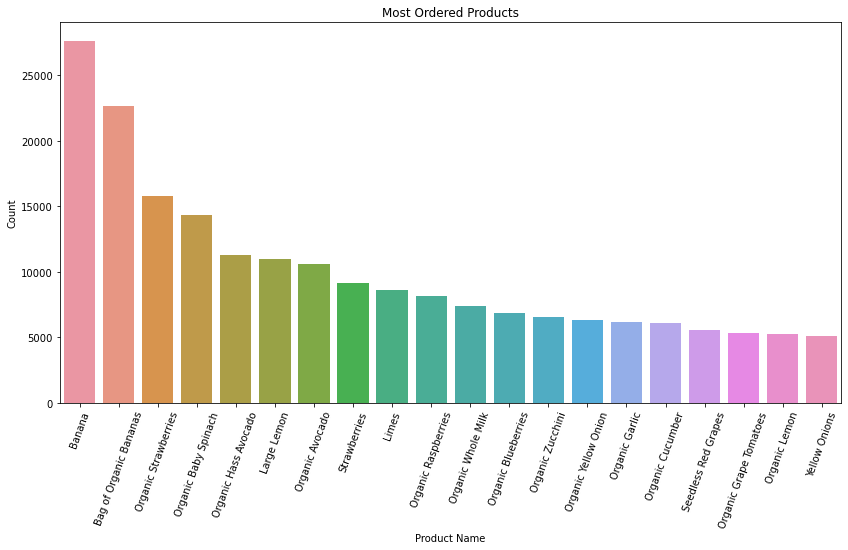

In [13]:
plt.figure(figsize = (14,7))
sns.countplot(x='product_name', data= order_products_desc, 
              order = order_products_desc.product_name.value_counts().index[:20])
plt.title('Most Ordered Products')
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.xlabel('Product Name')


Text(0.5, 0, 'Department')

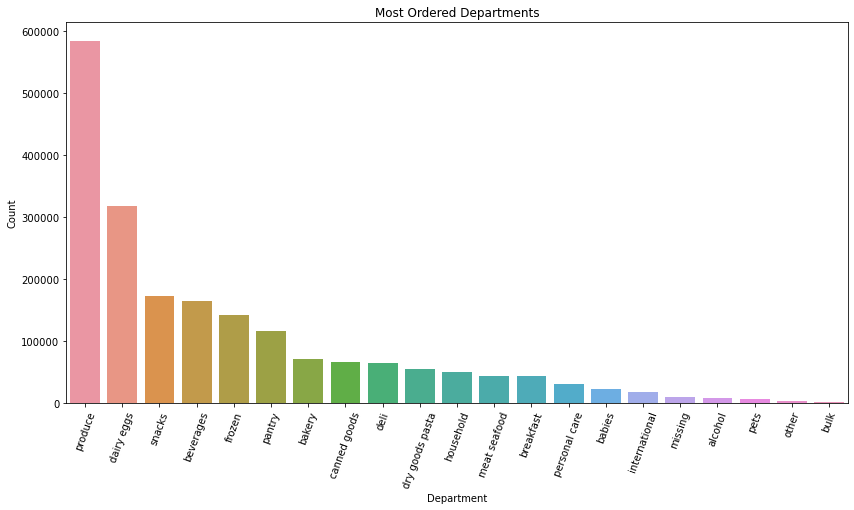

In [14]:
plt.figure(figsize = (14,7))
sns.countplot(x='department', data= order_products_desc, order = order_products_desc.department.value_counts().index)
plt.title('Most Ordered Departments')
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.xlabel('Department')


Text(0.5, 0, 'Aisle')

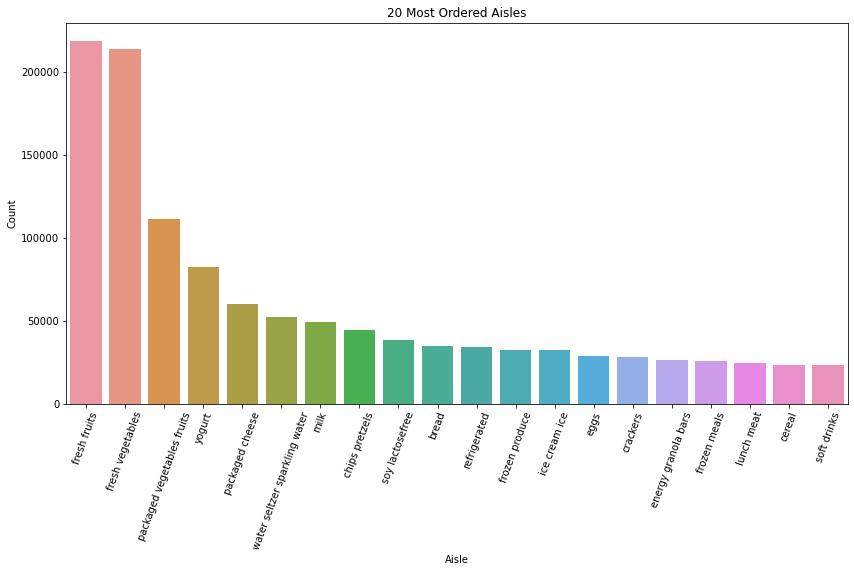

In [15]:
plt.figure(figsize = (14,7))
sns.countplot(x='aisle', data= order_products_desc, order = order_products_desc.aisle.value_counts().index[:20])
plt.title('20 Most Ordered Aisles')
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.xlabel('Aisle')


### Merge user orders

In [16]:
# Now merge the orders with the ordered prodcuts, combining on order_id
# This is a lot of info. We will trim some out before modeling.
merged_orders = pd.merge(orders, order_products_desc, on = 'order_id')
merged_orders.head() # Because the products showing are from the 1st order for this user, they all have Nan in days_since
# Because pd.merge defaults to an inner join, the test orders are not in this dataframe because they had no products.

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1187899,1,train,11,4,8,14.0,49235,10,1,Organic Half & Half,53,16,cream,dairy eggs
1,1187899,1,train,11,4,8,14.0,46149,11,1,Zero Calorie Cola,77,7,soft drinks,beverages
2,1187899,1,train,11,4,8,14.0,196,1,1,Soda,77,7,soft drinks,beverages
3,1187899,1,train,11,4,8,14.0,27845,9,0,Organic Whole Milk,84,16,milk,dairy eggs
4,1187899,1,train,11,4,8,14.0,38928,3,1,0% Greek Strained Yogurt,120,16,yogurt,dairy eggs


In [17]:
len(merged_orders)


1988252

In [18]:
merged_orders[merged_orders['user_id']==1] # We see 12 orders, 88 products, no test order


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1187899,1,train,11,4,8,14.0,49235,10,1,Organic Half & Half,53,16,cream,dairy eggs
1,1187899,1,train,11,4,8,14.0,46149,11,1,Zero Calorie Cola,77,7,soft drinks,beverages
2,1187899,1,train,11,4,8,14.0,196,1,1,Soda,77,7,soft drinks,beverages
3,1187899,1,train,11,4,8,14.0,27845,9,0,Organic Whole Milk,84,16,milk,dairy eggs
4,1187899,1,train,11,4,8,14.0,38928,3,1,0% Greek Strained Yogurt,120,16,yogurt,dairy eggs
5,1187899,1,train,11,4,8,14.0,26088,8,1,Aged White Cheddar Popcorn,23,19,popcorn jerky,snacks
6,1187899,1,train,11,4,8,14.0,39657,5,1,Milk Chocolate Almonds,45,19,candy chocolate,snacks
7,1187899,1,train,11,4,8,14.0,26405,4,1,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods,household
8,1187899,1,train,11,4,8,14.0,10258,6,1,Pistachios,117,19,nuts seeds dried fruit,snacks
9,1187899,1,train,11,4,8,14.0,13032,7,1,Cinnamon Toast Crunch,121,14,cereal,breakfast


In [19]:
merged_orders.shape

(1988252, 15)

In [20]:
orders[orders['user_id']==3]


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
26,1374495,3,prior,1,1,14,NaN
27,444309,3,prior,2,3,19,9.0
28,3002854,3,prior,3,3,16,21.0
29,2037211,3,prior,4,2,18,20.0
30,2710558,3,prior,5,0,17,12.0
31,1972919,3,prior,6,0,16,7.0
32,1839752,3,prior,7,0,15,7.0
33,3225766,3,prior,8,0,17,7.0
34,3160850,3,prior,9,0,16,7.0
35,676467,3,prior,10,3,16,17.0


In [21]:
# Creating the test set of orders
test = orders[orders['eval_set']=='test']
test.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


In [22]:
#Now I can see everything a particular user has ordered, and how often
merged_orders[merged_orders['user_id']==59]['product_name'].value_counts()

Fruit Spread, Deluxe, Strawberry                        1
Multigrain Cereal                                       1
Yobaby Organic Plain Yogurt                             1
Organic Baby Spinach Salad                              1
Hand Picked Pomegranate Seeds/Arils                     1
85% Ground Beef Patties                                 1
Bag of Organic Bananas                                  1
Organic Spelt Pretzels                                  1
Gluten Free Oatmeal Cookie Granola Bars Granola Bars    1
Half & Half                                             1
Unsalted Butter                                         1
Organic Unbleached All-Purpose Flour                    1
Berry Medley                                            1
Toasted Coconut Almondmilk Blend                        1
Organic Hass Avocado                                    1
Organic Original Hommus                                 1
Stage 1 Just Sweet Peas With Mint Baby Food             1
Apple and Carr

In [23]:
# import squarify

# a = merged_orders.groupby('department')[['aisle']].sum().index.get_level_values(0).tolist() 
# d = merged_orders.groupby('department')[['aisle']].count().reset_index().aisle.values.tolist()
# plt.figure(figsize=(12,8)) 
# squarify.plot(sizes=d,label=a,alpha=0.85 )
# plt.axis('off')
# plt.show()

#### Model-based Collaborative Filtering Systems
#### SVD Matrix Factorization

In [24]:
import sklearn
from sklearn.decomposition import TruncatedSVD

In [25]:
### remove random rows due to memory
remove_n = 1980000
drop_indices = np.random.choice(merged_orders.index, remove_n, replace=False)
df = merged_orders.drop(drop_indices)

In [26]:
df.shape

(8252, 15)

In [27]:
df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
315,1864787,43,train,12,5,11,26.0,4920,20,1,Seedless Red Grapes,123,4,packaged vegetables fruits,produce
392,1750084,50,train,68,3,9,7.0,21903,5,1,Organic Baby Spinach,123,4,packaged vegetables fruits,produce
434,39325,55,train,8,2,18,30.0,7413,4,1,Chocolate Peppermint Stick Bar,3,19,energy granola bars,snacks
634,44604,75,prior,11,4,11,6.0,28058,11,1,Gluten Free Sliced Mountain White Bread,112,3,bread,bakery
653,1700658,78,train,7,6,11,7.0,29127,3,0,Dairy Free Unsweetened Coconut Milk,91,16,soy lactosefree,dairy eggs


In [28]:

df.drop(['product_id','aisle_id','department_id','eval_set'], axis='columns', inplace=True)


In [29]:
df.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,product_name,aisle,department
315,1864787,43,12,5,11,26.0,20,1,Seedless Red Grapes,packaged vegetables fruits,produce
392,1750084,50,68,3,9,7.0,5,1,Organic Baby Spinach,packaged vegetables fruits,produce
434,39325,55,8,2,18,30.0,4,1,Chocolate Peppermint Stick Bar,energy granola bars,snacks
634,44604,75,11,4,11,6.0,11,1,Gluten Free Sliced Mountain White Bread,bread,bakery
653,1700658,78,7,6,11,7.0,3,0,Dairy Free Unsweetened Coconut Milk,soy lactosefree,dairy eggs


In [30]:
df. dropna()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,product_name,aisle,department
315,1864787,43,12,5,11,26.0,20,1,Seedless Red Grapes,packaged vegetables fruits,produce
392,1750084,50,68,3,9,7.0,5,1,Organic Baby Spinach,packaged vegetables fruits,produce
434,39325,55,8,2,18,30.0,4,1,Chocolate Peppermint Stick Bar,energy granola bars,snacks
634,44604,75,11,4,11,6.0,11,1,Gluten Free Sliced Mountain White Bread,bread,bakery
653,1700658,78,7,6,11,7.0,3,0,Dairy Free Unsweetened Coconut Milk,soy lactosefree,dairy eggs
...,...,...,...,...,...,...,...,...,...,...,...
1986705,339088,206050,4,1,8,30.0,6,0,Disinfecting Wipes Lemon,cleaning products,household
1987206,2682845,206108,14,0,18,27.0,45,0,Organic Italian Salad,packaged vegetables fruits,produce
1987232,2682845,206108,14,0,18,27.0,49,1,Edamame In Pod,frozen produce,frozen
1987406,1611487,206123,29,5,12,17.0,14,0,Dulce De Leche Sugar Free Pudding,refrigerated pudding desserts,dairy eggs


In [31]:
df.groupby('order_id')['order_number'].count().sort_values(ascending=False).head()

order_id
2434000    3
2218116    3
15231      3
51284      3
948508     3
Name: order_number, dtype: int64

In [34]:
Filter = df['order_id']==2434000
df[Filter]['product_name'].unique()


# to be analyse later, we need to find a unique caracteriscs of a product eg. rating, cost, ...

array(['Organic Avocado', 'Whole Almonds', 'Organic Red Onion'],
      dtype=object)

### Building a utility matrix 

In [35]:
order_number_crosstab = df.pivot_table(values ='order_number', index='user_id', columns ='product_name', fill_value=0)

In [36]:
order_number_crosstab.head()

product_name,0% Fat Free Organic Milk,0% Fat Organic Greek Vanilla Yogurt,0% Greek Strained Yogurt,1 % Lowfat Milk,1 Apple + 1 Mango Fruit Bar,1 Apple + 1 Pear Fruit Bar,1 Liter,1% Low Fat Milk,1% Lowfat Milk,1% Milkfat Low Fat Buttermilk,...,Zero Calorie Sweetener,Zero Grain Turkey Dog Food,Zero Ion4 Grape Sports Drink,Zero Ultra Energy Drink,Zesty Lemon Hommus,Zucchini Noodles,Zucchini Squash,"Zucchini Squash, Baby Courgette",of Hanover 100 Calorie Pretzels Mini,with Xylitol Original Flavor 18 Sticks Sugar Free Gum
user_id,,,,,,,,,,,,,,,,,,,,,
43,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
order_number_crosstab.shape

(7899, 4084)

### Transposing matrix

In [38]:
X = order_number_crosstab.T

In [39]:
X.shape

(4084, 7899)

### Decomposing matrix

In [41]:
SVD = TruncatedSVD(n_components =12, random_state = 17)
resultant_matrix = SVD.fit_transform(X)
resultant_matrix.shape

(4084, 12)

### Generating a Correlation Matrix

In [42]:
corr_mat = np.corrcoef(resultant_matrix)
corr_mat.shape

(4084, 4084)

### Isolating Fresh Cauliflower From the Correlation Matrix

In [43]:
product_names = order_number_crosstab.columns
product_list = list(product_names)

Fresh_Cauliflower = product_list.index('Fresh Cauliflower')
Fresh_Cauliflower

1160

In [46]:
corr_Fresh_Cauliflower = corr_mat[Fresh_Cauliflower] ##corr_Fresh_Cauliflower = corr_mat[1160]
corr_Fresh_Cauliflower.shape

(4084,)

#### Recommending a Highly Correlated Movie

In [48]:
list(product_names[(corr_Fresh_Cauliflower<1.0) & (corr_Fresh_Cauliflower > 0.9)])


['Boneless Beef Short Ribs',
 'Fresh Ginger Root',
 'Half And Half',
 'House Blend Deep Roast Ground Coffee',
 'Organic Beans & Rice Cheddar Cheese Burrito',
 'Organic Chewy Peanut Butter Banana Bites',
 'Organic Ground Ceylon Cinnamon',
 'Organic Mint',
 'Organic Regular Cotton Tampons No Applicator',
 'Organic SprouTofu Super Firm Tofu',
 'Reduced Fat Crescent Rolls',
 'Sweet Sliced Apples']

In [49]:
list(product_names[(corr_Fresh_Cauliflower<1.0) & (corr_Fresh_Cauliflower > 0.95)])

['Fresh Ginger Root', 'Reduced Fat Crescent Rolls']